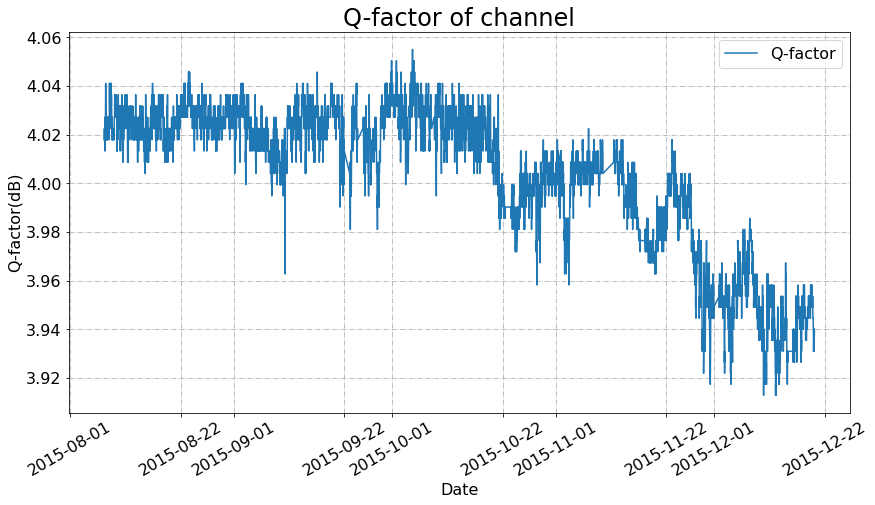

<ipython-input-12-50b57322cf27>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['SNR'] = scaler.transform(train[['SNR']])
<ipython-input-12-50b57322cf27>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['SNR'] = scaler.transform(test[['SNR']])


Training shape: (7517, 100, 1)
Testing shape: (4979, 100, 1)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 100, 128)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 128)          131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 100, 128)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 100, 1)            129       
Total params: 198,273
Trainable params: 198,273
Non-trainab

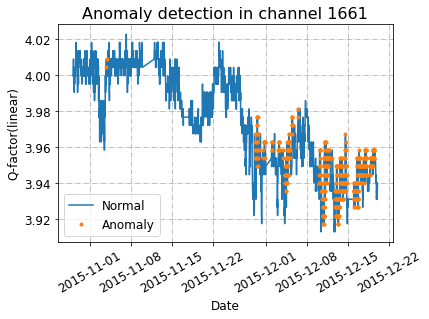

<Figure size 1008x504 with 0 Axes>

In [12]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.graph_objects as go
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

#loading data
df = pd.read_excel('.../channel_1661.xlsx')
df = df[['date', 'SNR']]
df['date'] = pd.to_datetime(df['date'])
df['date'].min(), df['date'].max()

#plot original data
plt.plot(df['date'], df['SNR'], label='Q-factor')
plt.title('Q-factor of channel',fontsize = 24)
plt.xlabel('Date',fontsize = 16)
plt.ylabel('Q-factor(dB)',fontsize = 16)
plt.tick_params(labelsize=16) 
plt.xticks(rotation=30)
plt.legend(fontsize = 16,loc='upper right')
plt.grid(linestyle='-.')
plt.show()

#create input
train_size = int(len(df) * 0.6)

train = df[:train_size]  
test = df[train_size:]
train.shape, test.shape

scaler = StandardScaler()
scaler = scaler.fit(train[['SNR']])

train['SNR'] = scaler.transform(train[['SNR']])
test['SNR'] = scaler.transform(test[['SNR']])

TIME_STEPS=100

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['SNR']], train['SNR'])
X_test, y_test = create_sequences(test[['SNR']], test['SNR'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

#create and fit encoder-decoder LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()


history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)


model.evaluate(X_test, y_test)

X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)


threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)


test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['SNR'] = test[TIME_STEPS:]['SNR']


anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

#plot anomalies
plt.plot(test_score_df['date'], scaler.inverse_transform(test_score_df['SNR'].values.reshape(-1,1)), label='Normal')
plt.plot(anomalies['date'], scaler.inverse_transform(anomalies['SNR'].values.reshape(-1,1)), '.', label='Anomaly')
plt.title('Anomaly detection in channel 1661',fontsize=16)
plt.xlabel('Date',fontsize = 12)
plt.ylabel('Q-factor(linear)',fontsize = 12)
plt.tick_params(labelsize=12) 
plt.xticks(rotation=30)
plt.legend(fontsize = 12,loc='lower left')
plt.grid(linestyle='-.')
plt.figure(figsize=(14,7))
plt.show()